<a href="https://colab.research.google.com/github/adithyans369/strawberry_model/blob/main/strawberry_growth_prediction__final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import zipfile
import shutil
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.regularizers import l2
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import unittest


In [2]:
TRAIN_ZIP_PATH = "/content/strawberry_dataset.zip"
TEST_ZIP_PATH = "/content/testimgran.zip"

TRAIN_EXTRACT_PATH = "/content/train_dataset"
TEST_EXTRACT_PATH = "/content/test_dataset"

IMG_SIZE = (224, 224)
BATCH_SIZE = 32
EPOCHS = 30
CLASS_NAMES = ['ripe', 'turning', 'unripe']
MODEL_SAVE_PATH = "/content/mobilenetv2_fruit_classifier.h5"


In [3]:
# Unzip training dataset
with zipfile.ZipFile(TRAIN_ZIP_PATH, 'r') as zip_ref:
    zip_ref.extractall(TRAIN_EXTRACT_PATH)

# Move class folders up if needed
train_root = TRAIN_EXTRACT_PATH
inner_folders = os.listdir(train_root)
if len(inner_folders) == 1:
    inner_path = os.path.join(train_root, inner_folders[0])
    if os.path.isdir(inner_path):
        for item in os.listdir(inner_path):
            shutil.move(os.path.join(inner_path, item), train_root)
        os.rmdir(inner_path)

print("Training folders:", os.listdir(TRAIN_EXTRACT_PATH))

# Unzip test dataset
with zipfile.ZipFile(TEST_ZIP_PATH, 'r') as zip_ref:
    zip_ref.extractall(TEST_EXTRACT_PATH)

print("Test dataset extracted to", TEST_EXTRACT_PATH)


Training folders: ['turning', 'unripe', 'ripe']
Test dataset extracted to /content/test_dataset


In [8]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Train datagen WITH augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2
)

# Val datagen WITHOUT augmentation (just rescale)
val_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

# Train generator
train_gen = train_datagen.flow_from_directory(
    TRAIN_EXTRACT_PATH,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

# Val generator
val_gen = val_datagen.flow_from_directory(
    TRAIN_EXTRACT_PATH,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)


Found 1208 images belonging to 3 classes.
Found 301 images belonging to 3 classes.


In [9]:
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

for layer in base_model.layers[:-80]:
    layer.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)
x = Dense(128, activation='relu', kernel_regularizer=l2(0.001))(x)
output = Dense(len(CLASS_NAMES), activation='softmax', kernel_regularizer=l2(0.001))(x)

model = Model(inputs=base_model.input, outputs=output)

model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer_1[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,422,339 (9.24 MB)

 Trainable params: 2,232,067 (8.51 MB)

 Non-trainable params: 190,272 (743.25 KB)

In [10]:
from tensorflow.keras.callbacks import EarlyStopping

# Early stopping to prevent overfitting
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,               # Stop if val_loss doesn't improve for 5 epochs
    restore_best_weights=True,
    verbose=1
)

# Fit the model
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=EPOCHS,
    callbacks=[early_stop]
)

# Save the model
model.save(MODEL_SAVE_PATH)
print(f"Model saved to {MODEL_SAVE_PATH}")


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 656ms/step - accuracy: 0.7496 - loss: 0.8866

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


38/38 ━━━━━━━━━━━━━━━━━━━━ 57s 815ms/step - accuracy: 0.7525 - loss: 0.8799 - val_accuracy: 0.8837 - val_loss: 0.5071
Epoch 2/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 16s 412ms/step - accuracy: 0.9499 - loss: 0.3896 - val_accuracy: 0.9734 - val_loss: 0.3417
Epoch 3/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 16s 411ms/step - accuracy: 0.9818 - loss: 0.2940 - val_accuracy: 0.9801 - val_loss: 0.3012
Epoch 4/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 15s 405ms/step - accuracy: 0.9898 - loss: 0.2623 - val_accuracy: 0.9369 - val_loss: 0.3668
Epoch 5/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 21s 413ms/step - accuracy: 0.9885 - loss: 0.2708 - val_accuracy: 0.9834 - val_loss: 0.2869
Epoch 6/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 16s 409ms/step - accuracy: 0.9912 - loss: 0.2524 - val_accuracy: 0.9668 - val_loss: 0.3288
Epoch 7/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 17s 439ms/step - accuracy: 0.9917 - loss: 0.2656 - val_accuracy: 0.9336 - val_loss: 0.3915
Epoch 8/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 15s 407ms/step - accuracy: 0.9922 - loss: 0.2436 - val_accuracy: 0.963

Model saved to /content/mobilenetv2_fruit_classifier.h5


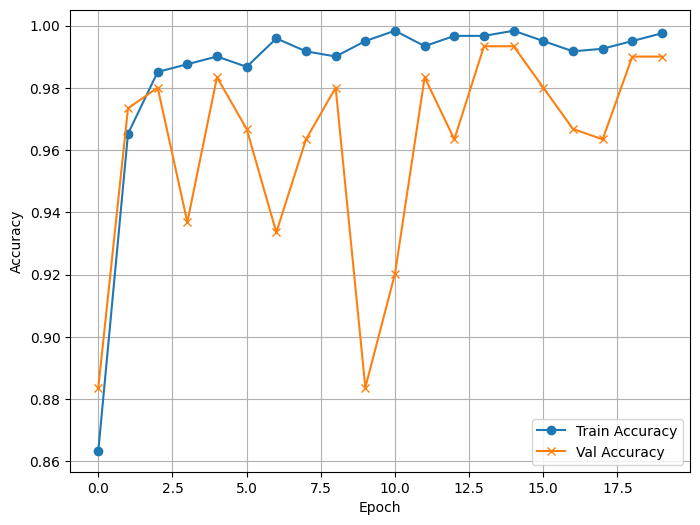

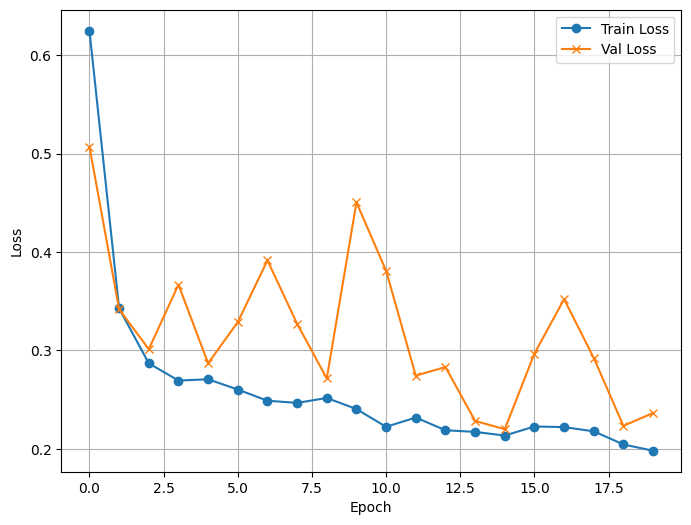

In [11]:
plt.figure(figsize=(8, 6))
plt.plot(history.history['accuracy'], label='Train Accuracy', marker='o')
plt.plot(history.history['val_accuracy'], label='Val Accuracy', marker='x')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Train Loss', marker='o')
plt.plot(history.history['val_loss'], label='Val Loss', marker='x')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


Found 13 test images.
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


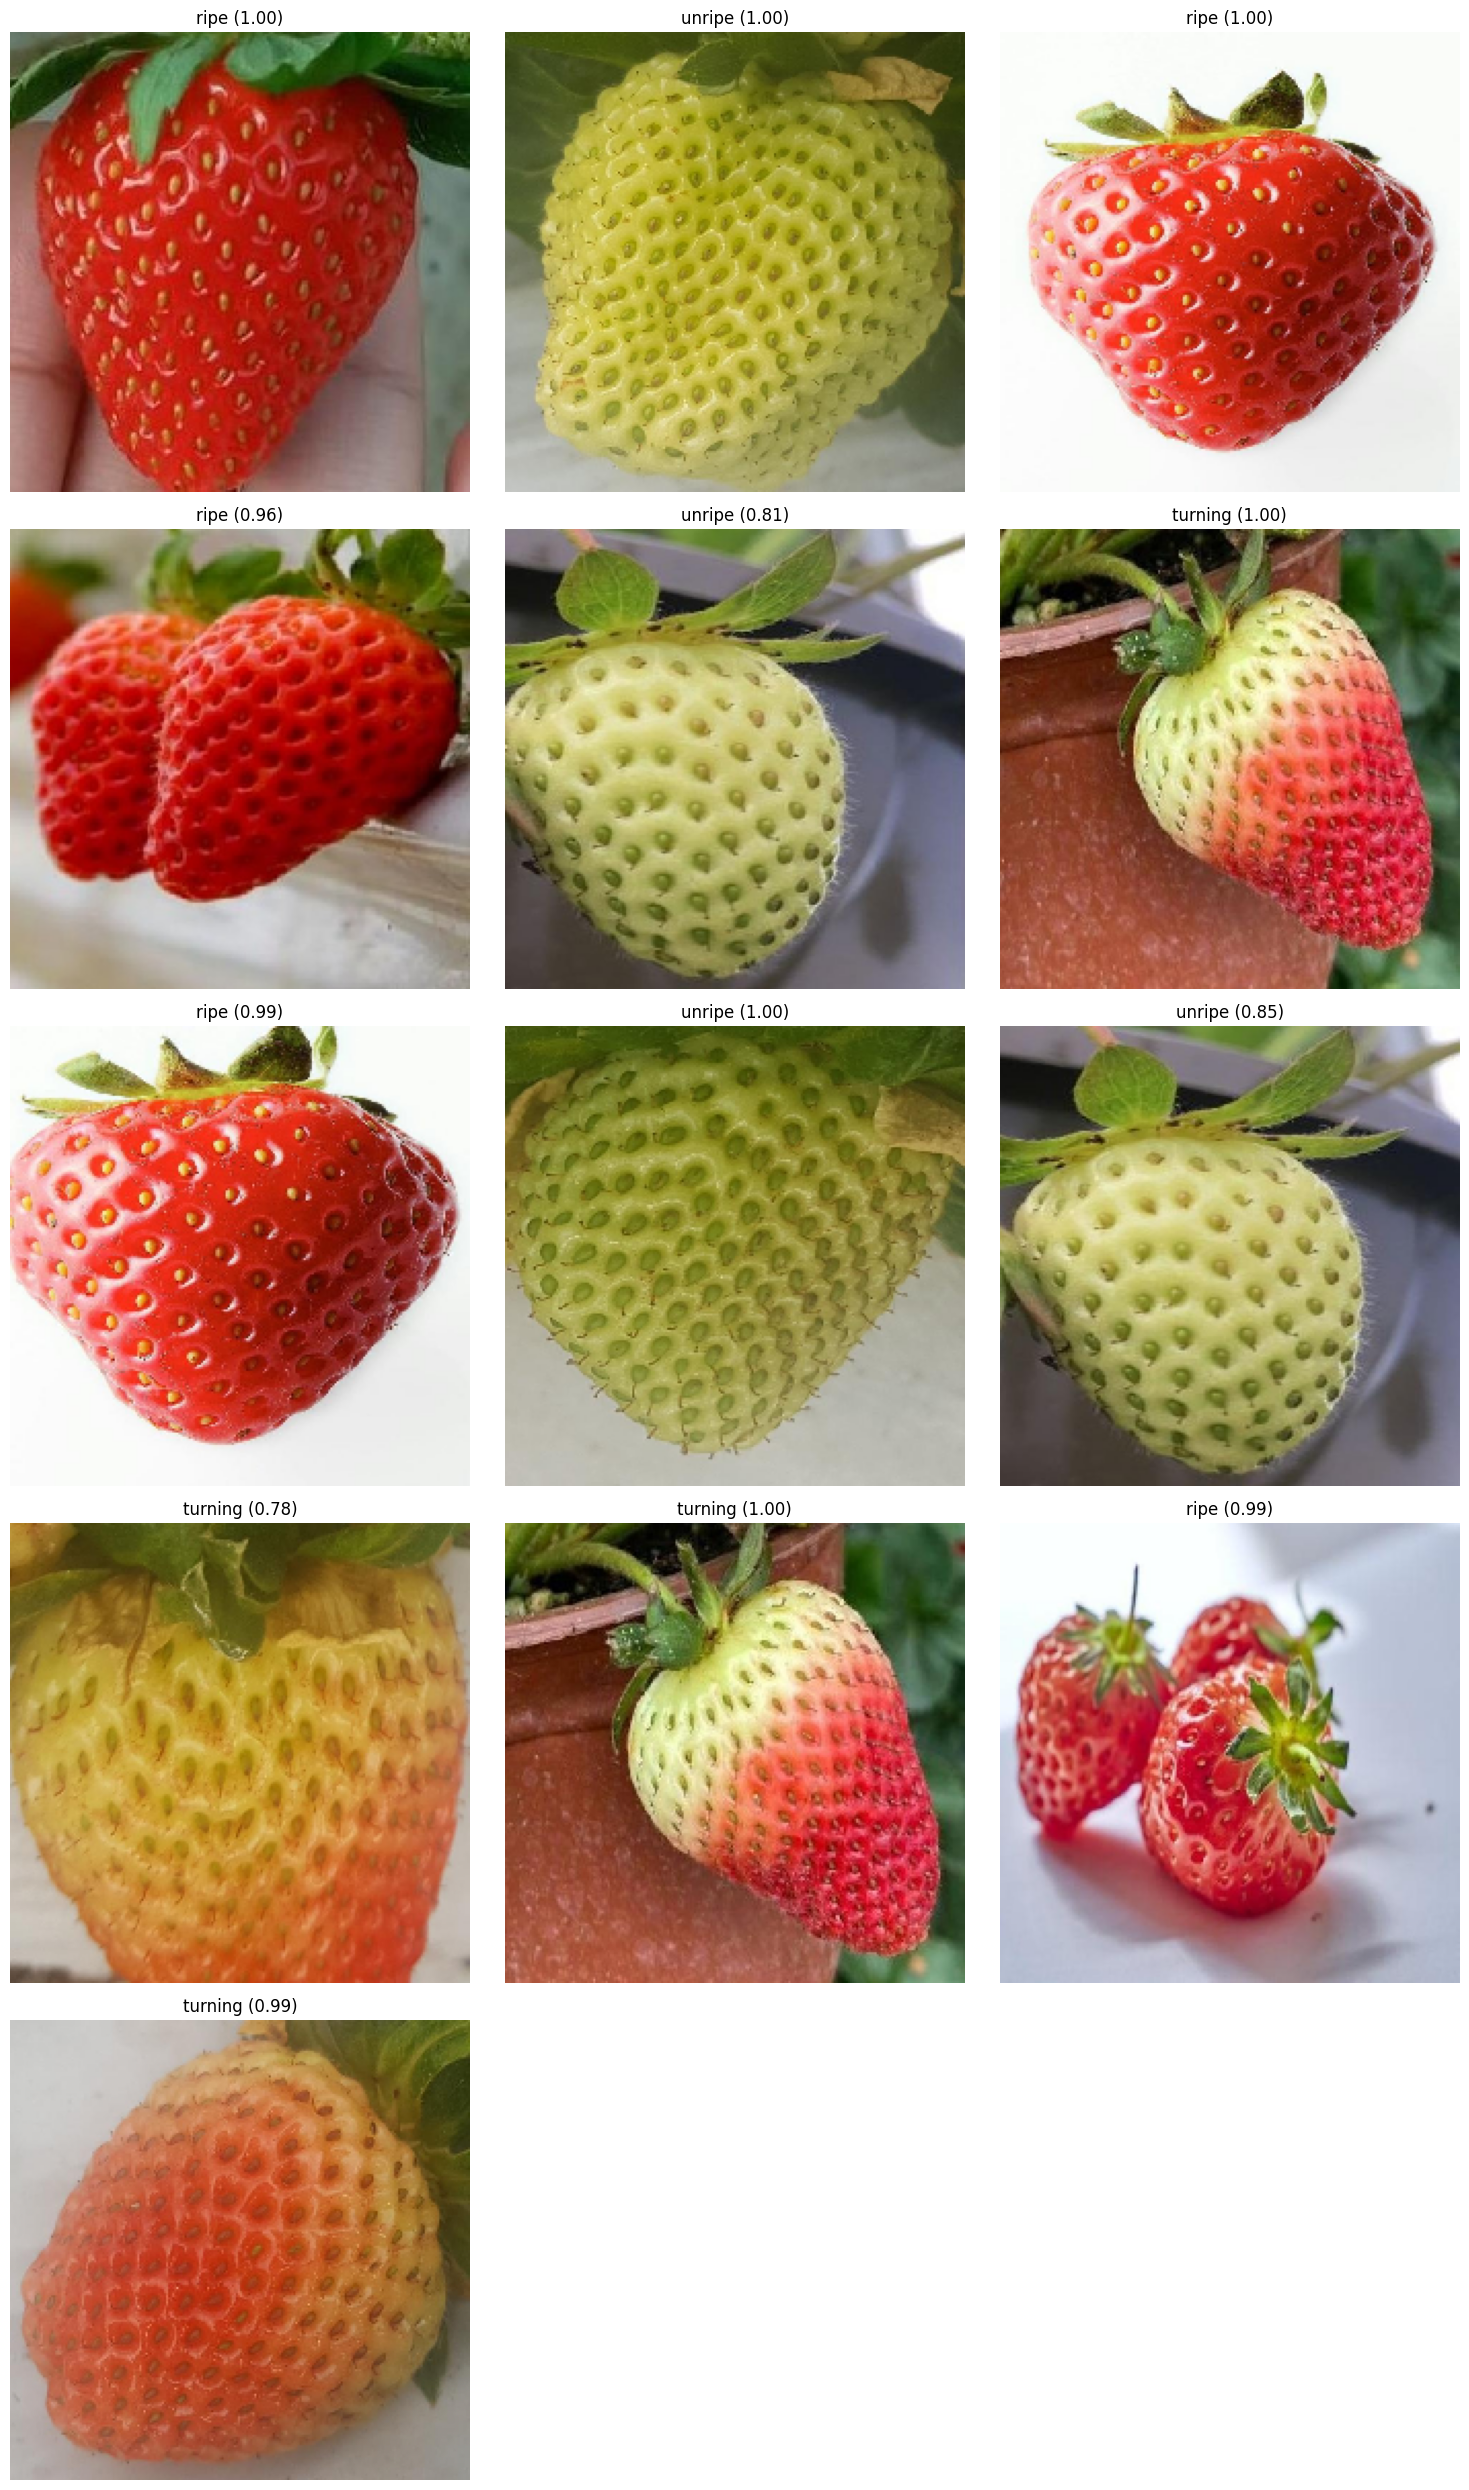

In [14]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import matplotlib.pyplot as plt
from glob import glob
import numpy as np
import os

# Set test image directory — top-level extracted path
# (no need to hardcode testimages/testimgran; we’ll search all subfolders)
test_image_dir = TEST_EXTRACT_PATH

# Find image paths recursively
test_image_paths = glob(os.path.join(test_image_dir, "**", "*.*"), recursive=True)
test_image_paths = [
    p for p in test_image_paths
    if p.lower().endswith(('.jpg', '.jpeg', '.png'))
]

print(f"Found {len(test_image_paths)} test images.")

# Plot predictions
if test_image_paths:
    plt.figure(figsize=(15, 5 * ((len(test_image_paths) + 2) // 3)))

    for idx, img_path in enumerate(test_image_paths):
        img = load_img(img_path, target_size=IMG_SIZE)
        img_array = img_to_array(img)
        img_array = np.expand_dims(img_array, axis=0) / 255.0

        prediction = model.predict(img_array)
        predicted_idx = np.argmax(prediction[0])
        predicted_label = CLASS_NAMES[predicted_idx]
        confidence = prediction[0][predicted_idx]

        plt.subplot((len(test_image_paths) + 2) // 3, 3, idx + 1)
        plt.imshow(img)
        plt.title(f"{predicted_label} ({confidence:.2f})")
        plt.axis('off')

    plt.tight_layout()
    plt.show()
else:
    print("No test images found. Please check your TEST_EXTRACT_PATH and its contents.")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


<Figure size 600x600 with 0 Axes>

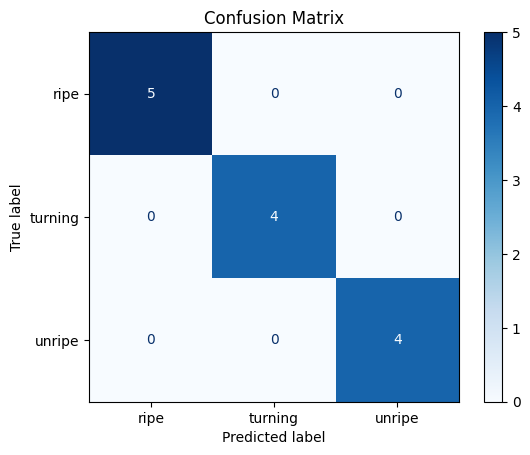

Saved confusion matrix to /content/confusion_matrix.png


<Figure size 640x480 with 0 Axes>

In [16]:
# Fill true labels based on your test images
true_labels_order = ['ripe', 'unripe', 'ripe', 'ripe', 'unripe', 'turning',
                     'ripe', 'unripe', 'unripe', 'turning', 'turning',
                     'ripe', 'turning']


if len(true_labels_order) != len(test_image_paths):
    print("Error: true_labels_order length does not match test images")
else:
    y_true = [CLASS_NAMES.index(lbl) for lbl in true_labels_order]
    y_pred = []

    for img_path in test_image_paths:
        img = load_img(img_path, target_size=IMG_SIZE)
        img_array = img_to_array(img)
        img_array = np.expand_dims(img_array, axis=0) / 255.0
        pred = model.predict(img_array)
        y_pred.append(np.argmax(pred[0]))

    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=CLASS_NAMES)
    plt.figure(figsize=(6, 6))
    disp.plot(cmap='Blues', values_format='d')
    plt.title("Confusion Matrix")
    plt.show()

    plt.savefig("/content/confusion_matrix.png")
    print("Saved confusion matrix to /content/confusion_matrix.png")


Saving test12.jpeg to test12.jpeg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Predicted: unripe (confidence 1.00)


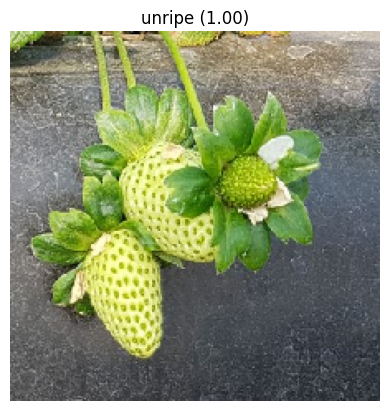

In [17]:
from google.colab import files

uploaded = files.upload()

for fname in uploaded.keys():
    img = load_img(fname, target_size=IMG_SIZE)
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0) / 255.0
    pred = model.predict(img_array)
    idx = np.argmax(pred[0])
    label = CLASS_NAMES[idx]
    conf = pred[0][idx]

    print(f"Predicted: {label} (confidence {conf:.2f})")
    plt.imshow(img)
    plt.title(f"{label} ({conf:.2f})")
    plt.axis('off')
    plt.show()


In [22]:
import unittest
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array

class TestFruitModelPipeline(unittest.TestCase):

    @classmethod
    def setUpClass(cls):
        # Load model once for all tests
        cls.model = tf.keras.models.load_model(MODEL_SAVE_PATH)

    def test_model_loads(self):
        """Test that model loads and output shape is as expected"""
        self.assertIsNotNone(self.model, "Model failed to load")
        self.assertEqual(
            self.model.output_shape[-1],
            len(CLASS_NAMES),
            f"Expected output shape last dim {len(CLASS_NAMES)}, got {self.model.output_shape[-1]}"
        )

    def test_single_image_prediction(self):
        """Test model predicts valid class index for a single image"""
        if not test_image_paths:
            self.skipTest("No test images available")
        img = load_img(test_image_paths[0], target_size=IMG_SIZE)
        arr = np.expand_dims(img_to_array(img), 0) / 255.0
        pred = self.model.predict(arr)
        idx = np.argmax(pred[0])
        self.assertIn(idx, range(len(CLASS_NAMES)), f"Invalid predicted class index: {idx}")

    def test_batch_prediction_shape(self):
        """Test batch prediction returns correct shape"""
        if len(test_image_paths) < 2:
            self.skipTest("Not enough test images for batch prediction test")
        batch = []
        for path in test_image_paths[:2]:
            img = load_img(path, target_size=IMG_SIZE)
            batch.append(img_to_array(img))
        batch = np.array(batch) / 255.0
        preds = self.model.predict(batch)
        self.assertEqual(
            preds.shape,
            (2, len(CLASS_NAMES)),
            f"Expected prediction shape (2, {len(CLASS_NAMES)}), got {preds.shape}"
        )


In [23]:
# Run the tests and save output to debug log
TEST_LOG_PATH = "/content/model_pipeline_test_log.txt"

with open(TEST_LOG_PATH, "w") as f:
    runner = unittest.TextTestRunner(stream=f, verbosity=2)
    unittest.main(argv=['first-arg-is-ignored'], testRunner=runner, exit=False)

print(f"Pipeline test log saved to: {TEST_LOG_PATH}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Pipeline test log saved to: /content/model_pipeline_test_log.txt
